In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# specify network parameters
datasize = 'full'
location = 'oslo'
data_date = '202208'
# specify evaluation data parameters
eval_date = '202209'

# load network from pickle
model = data_date+'_waypoints_DP10_HDBSCAN20_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202208_points_oslo_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 20,
 'clustering_min_cluster_size': 20,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = network.crs  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 816 (4 isolated)
Number of edges: 3860
------------------------


Evaluating graph on 7133 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 184.84 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.010795  0.010795   0.010795          0.010795  0.010795         0.010795
no_intersects  0.090986  0.000000   0.000000          0.090986  0.000000         0.000000
no_path        0.002243  0.000000   0.000000          0.002243  0.000000         0.000000
success        0.895976  0.895976   0.895976          0.895976  0.895976         0.895976

 --------------------------- 

Fraction of NaN results: 0.093

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.920 

Mean distance      = 177.05 m
Median distance    = 71.38 m
Standard deviation = 366.34 m 



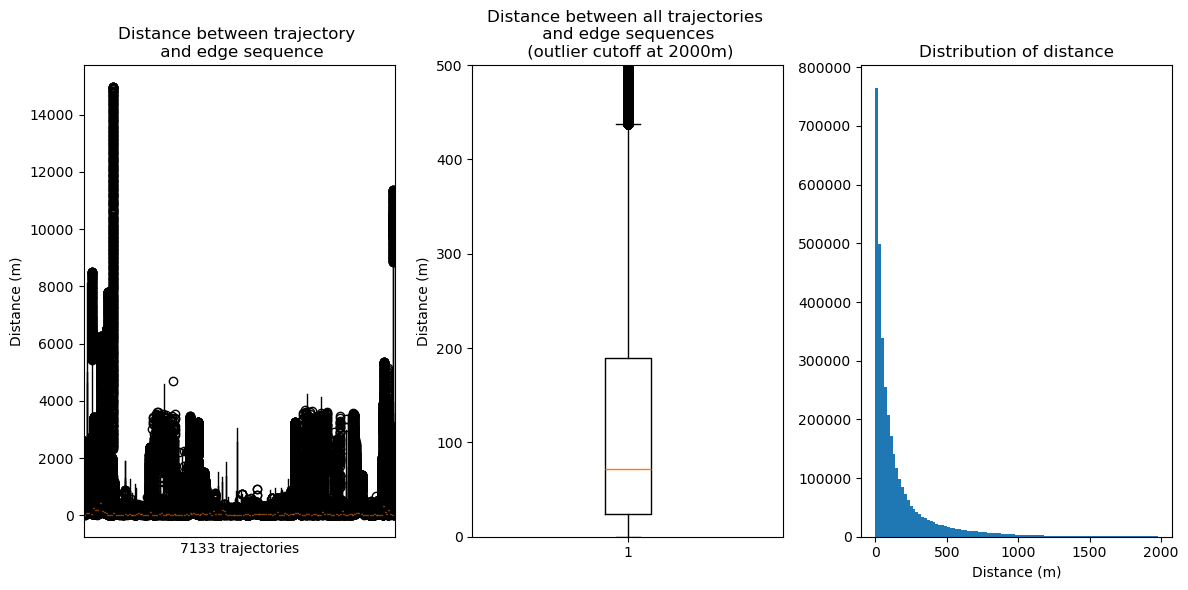

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [7]:
all_evaluation_results

,mmsi,SSPD,distances,fraction_covered,message,path,path_linestring
0,209210000_0_2022-09-15 03:13:09,29.501939,"[204.28326281234013, 199.69988286043773, 191.0...",0.424636,success,"[353, 349, 350, 50, 109, 110, 19, 20, 60, 24, ...","LINESTRING (609202.005966925 6543715.56858704,..."
0,209210000_3_2022-09-16 06:27:41,42.405722,"[2.0717465441748932, 5.1278388612285895, 6.885...",0.483626,success,"[411, 413, 412, 407, 416, 415, 397, 398, 406, ...",LINESTRING (618314.8903421772 6571663.70963889...
0,209214000_0_2022-09-10 04:18:00,297.511580,"[150.44064912186988, 155.86364031341756, 153.5...",0.846066,success,"[269, 271, 287, 302, 218, 359, 372, 357, 353, ...",LINESTRING (576143.6783495221 6523678.62458855...
0,209214000_4_2022-09-11 03:23:44,318.844271,"[13.03259983189205, 9.022295800250815, 2.53149...",0.981691,success,"[411, 413, 412, 407, 416, 415, 397, 398, 406, ...",LINESTRING (618314.8903421772 6571663.70963889...
0,209275000_0_2022-09-27 07:34:28,335.571491,"[295.2114441222989, 288.68450044906155, 290.20...",0.987916,success,"[189, 192, 191, 371, 372, 485, 486, 391, 384, ...",MULTILINESTRING ((599784.078630073 6531252.807...
...,...,...,...,...,...,...,...
0,636015105_1_2022-09-12 06:38:54,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,636015105_2_2022-09-17 10:17:42,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,636015944_0_2022-09-09 21:47:00,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,636022088_0_2022-09-08 13:00:20,NaN,NaN,0.000000,no_intersects,NaN,NaN


In [8]:
df = all_evaluation_results

In [9]:
# Filter out NaN results and bad examples
nan_mask = df.isna().any(axis=1)
df = df[~nan_mask]
#df = df[df['fraction_covered']>0.8]
#df = df[df['SSPD']<300]

In [10]:
# merge results with trajectory data and metadata
test_trajectories = test_trajectories.filter('mmsi', df['mmsi'].tolist())
traj_gdf = test_trajectories.to_traj_gdf()
merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe']
test_gdf.drop_duplicates(subset=['mmsi'], inplace=True)
test_gdf.rename(columns={'length': 'lengde'}, inplace=True)
traj_gdf = traj_gdf.merge(test_gdf[merge_columns], on='mmsi', how='left')

merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe', 'geometry']
df = df.merge(traj_gdf[merge_columns], on='mmsi', how='left')
df = gpd.GeoDataFrame(df)

In [11]:
df.to_csv(model+'_'+eval_date+'_paths_v2.csv')

In [12]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   mmsi              6468 non-null   object  
 1   SSPD              6468 non-null   float64 
 2   distances         6468 non-null   object  
 3   fraction_covered  6468 non-null   float64 
 4   message           6468 non-null   object  
 5   path              6468 non-null   object  
 6   path_linestring   6468 non-null   object  
 7   lengde            6468 non-null   object  
 8   bredde            3652 non-null   float64 
 9   dypgaaende        3621 non-null   float64 
 10  skipstype         3652 non-null   object  
 11  skipsgruppe       3652 non-null   object  
 12  geometry          6468 non-null   geometry
dtypes: float64(4), geometry(1), object(8)
memory usage: 657.0+ KB
